# Decision Tree for N-dimensional data and labels
The code below implements a **decision tree** calculated for labelled data as well as Random Forests.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.decision_tree_create import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *
from density_tree.random_forest import *

# Generic Functions
The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


### Generate Data

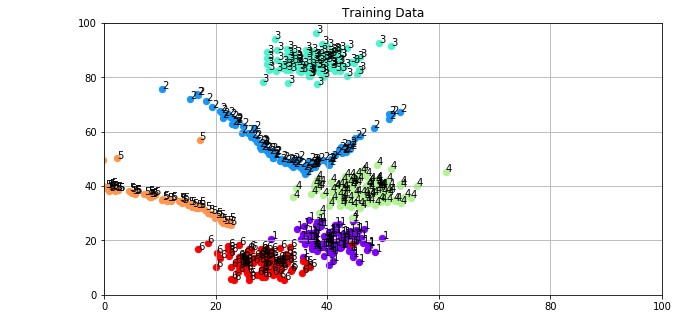

In [10]:
# cluster parameters
nclusters = 6
dimensions = 2
covariance = [20, 10]
minRange = 0
maxRange = 100
npoints = 100
    
dataset, clusters = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                                random_flip=False, nonlinearities = True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,5)
plot_data(clusters, "Training Data", ax, clusters=clusters, minrange=minRange, maxrange=maxRange, covariance=0)
plt.show()

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [11]:
root = create_decision_tree(dataset)

In [12]:
root.depth()

9

In [13]:
clusters.shape

(6, 100, 3)

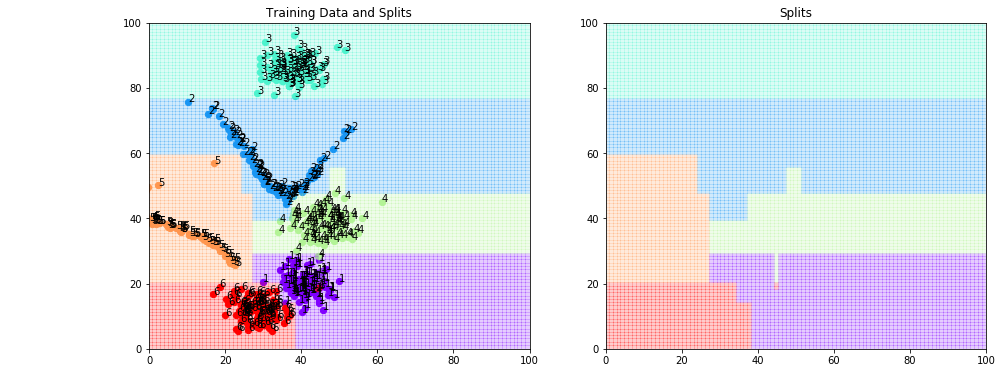

In [14]:
visualize_decision_boundaries(dataset, root, minRange, maxRange)

The overfitting of the tree clearly shows in the decision boundaries above. The naive decision tree simply splits the data all the way down to the point where every leaf node only contains one type of labels. This produces fairly correct classification, however the boundaries are not smooth and prone to overfitting.

# Output the decision forest to a $\LaTeX$ figure

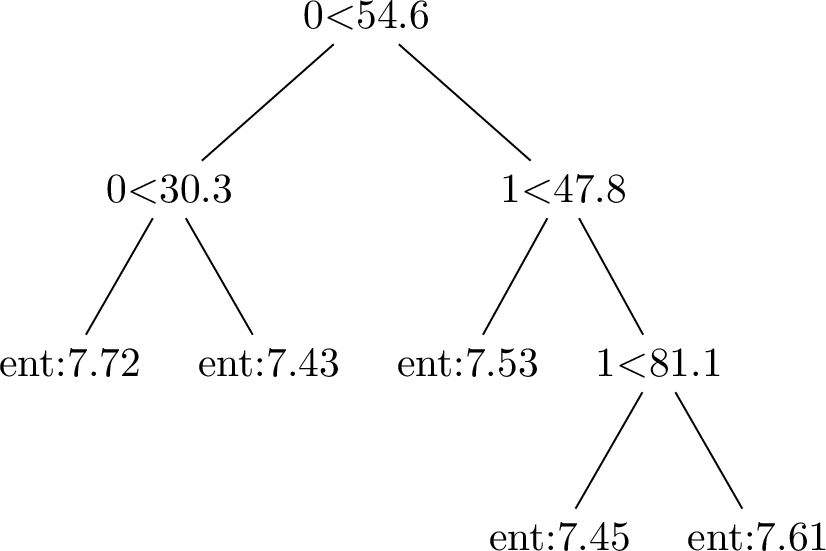

In [15]:
def tree_visualize(root_node):
    tree_string = ""
    tree_string = print_decision_tree_latex(root_node, tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;")
    os.system("echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; /Library/TeX/texbin/pdflatex main.tex;")
    os.system("convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

We can see that the Decision Tree overfits and creates way too many splits. We will thus train many individual trees on a subset of the data.


# Random Forest
- Draw random subsamples of data with replacement
- Create individual decision trees on subsamples
- Visualize decision boundaries

In [16]:
# build random forest
root_nodes = random_forest_build(dataset, 1000, .3, n_jobs=-1)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   58.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  2.7min finished


In [17]:
# evaluate labels of original dataset using RF
dataset_test = dataset[:, :2]
dataset_eval = random_forest_traverse(dataset_test, root_nodes)

A Jupyter Widget

A Jupyter Widget

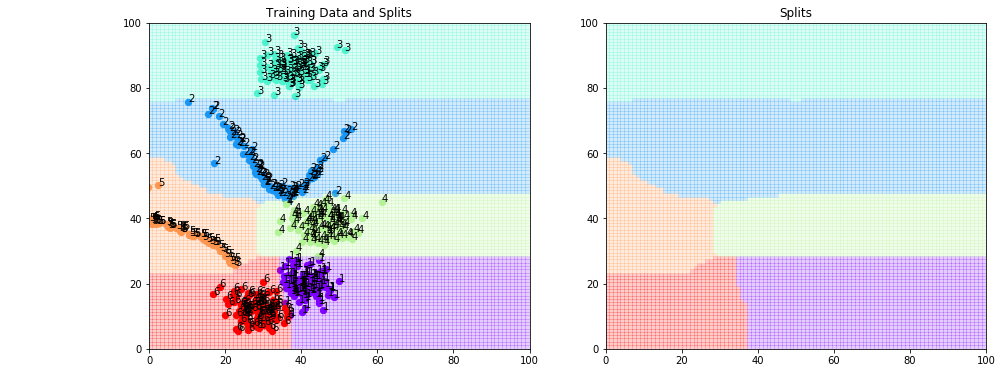

In [18]:
# show data using Random Forests
visualize_decision_boundaries(dataset_eval, root_nodes, minRange, maxRange, rf=True)

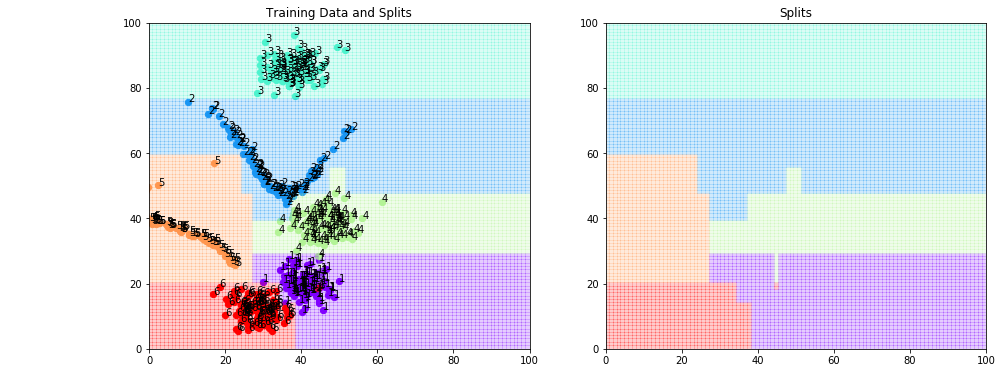

In [19]:
# compare to using only one decision tree:
visualize_decision_boundaries(dataset, root, minRange, maxRange)